In [1]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os
import sys

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
# 28x28 흑백 이미지를 그리기 위한 유틸리티 함수
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [3]:
# 3D data 생성
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

# 데이터 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

# 오토 인코더 모델 생성
import tensorflow as tf

reset_graph() # 일관된 출력을 위해 유사난수 초기화

n_inputs = 3
n_hidden = 2  # 코딩 유닛
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1 = tf.get_variable(name="weights1", shape = [n_inputs, n_hidden], initializer = tf.variance_scaling_initializer() )
weights2 = tf.transpose(weights1, name="weights2")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden), name="biases1")
biases2 = tf.Variable(tf.zeros(n_outputs), name="biases2")

hidden = tf.matmul(X, weights1) + biases1
outputs = tf.matmul(hidden, weights2) + biases2 

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [4]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


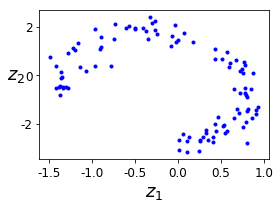

In [5]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

In [6]:
# 데이터 생성 mnist
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
# tf.examples.tutorials.mnist은 삭제될 예정 이라함

X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# 데이터를 섞고, batch 사이즈 만큼 분류 후 반환
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size # 나눗셈의 몫
    
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [7]:
# 가중치 공유하지 않는 outoencoder 3개의 중간 층 존재
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3) + regularizer(weights4)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        lo = loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "최종 loss:", lo)
        saver.save(sess, "./my_model_all_layers.ckpt") 


0 훈련 MSE: 0.041185044
0 최종 loss: 0.049380362
1 훈련 MSE: 0.03546396
1 최종 loss: 0.044484984
2 훈련 MSE: 0.039493706
2 최종 loss: 0.04841989
3 훈련 MSE: 0.038871415
3 최종 loss: 0.04780278
4 훈련 MSE: 0.037473794
4 최종 loss: 0.04645705


In [8]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 5):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
#         X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


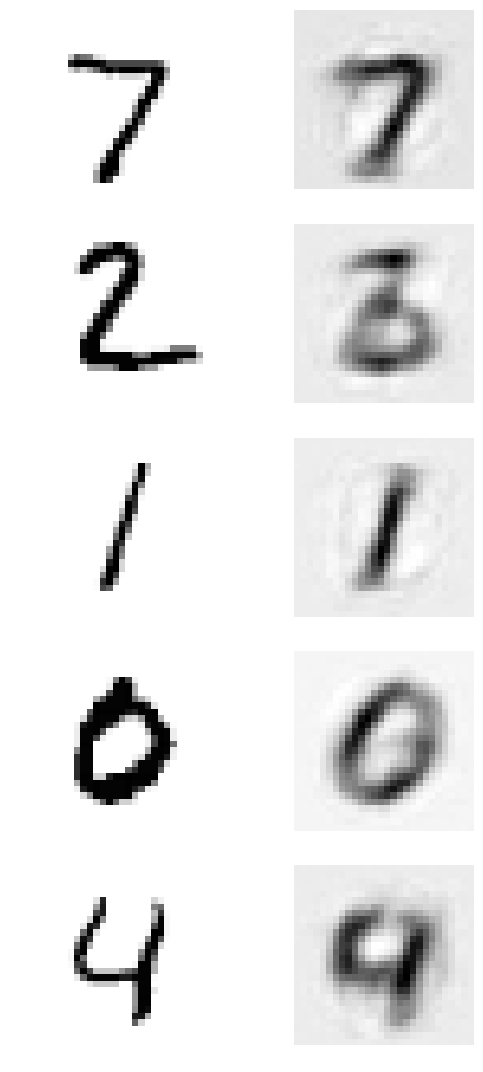

In [9]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

In [7]:
# get_Variable 사용
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1 = tf.get_variable(name="weights1", shape = [n_inputs, n_hidden1], initializer = tf.variance_scaling_initializer() )
weights2 = tf.get_variable(name="weights2", shape = [n_hidden1, n_hidden2], initializer = tf.variance_scaling_initializer())
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers2.ckpt")     

0 훈련 MSE: 0.031040253
1 훈련 MSE: 0.026425717
2 훈련 MSE: 0.028102614
3 훈련 MSE: 0.027138503
4 훈련 MSE: 0.026188966


INFO:tensorflow:Restoring parameters from ./my_model_all_layers2.ckpt


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


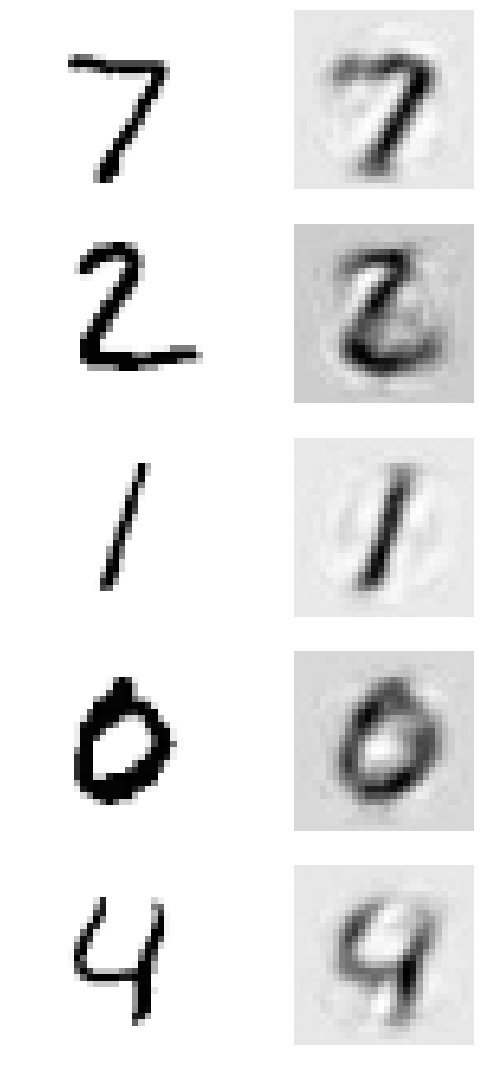

In [8]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 5):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
#         X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
show_reconstructed_digits(X, outputs, "./my_model_all_layers2.ckpt")
save_fig("reconstruction_plot2")

In [7]:
# 가중치 묶은 후 outoencoder 3개의 중간 층 존재
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # 책에는 없음

n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers3.ckpt") 
        

0 훈련 MSE: 0.031573415
1 훈련 MSE: 0.027345808
2 훈련 MSE: 0.028520076
3 훈련 MSE: 0.027276974
4 훈련 MSE: 0.026074812


INFO:tensorflow:Restoring parameters from ./my_model_all_layers3.ckpt


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


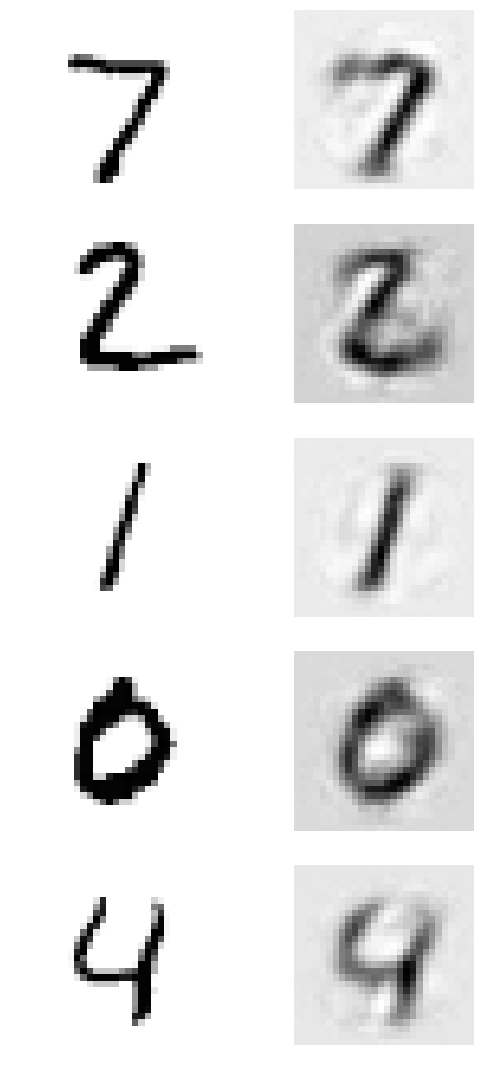

In [8]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 5):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
#         X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        
show_reconstructed_digits(X, outputs, "./my_model_all_layers3.ckpt")
save_fig("reconstruction_plot3")

In [12]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.relu, output_activation=tf.nn.relu):
    
    graph = tf.Graph()
    
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(tf.layers.dense, kernel_initializer=tf.variance_scaling_initializer(),
                                   kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [13]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(X_train, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

0 훈련 MSE: 0.018396782
1 훈련 MSE: 0.017695026
2 훈련 MSE: 0.019602837
3 훈련 MSE: 0.019349461
0 훈련 MSE: 0.004570487
1 훈련 MSE: 0.0048023695
2 훈련 MSE: 0.00477468
3 훈련 MSE: 0.0044500837


In [14]:
reset_graph()

n_inputs = 28*28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X_test, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

print(hidden3)
print(outputs)

Tensor("Elu_2:0", shape=(10000, 300), dtype=float32)
Tensor("add_3:0", shape=(10000, 784), dtype=float32)


In [15]:
def show_reconstructed_digits (X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
#         X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


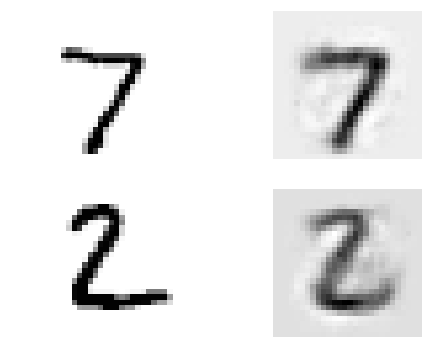

In [16]:
show_reconstructed_digits(X, outputs)

In [7]:
# 하나의 그래프에서 오토인코더를 따로따로 훈련하기
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1 = tf.get_variable(name="weights1", shape = [n_inputs, n_hidden1], initializer = tf.variance_scaling_initializer() )
weights2 = tf.get_variable(name="weights2", shape = [n_hidden1, n_hidden2], initializer = tf.variance_scaling_initializer())
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [8]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # hidden2와 hidden3 통과합니다
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, biases3] # weight3 는 weught2의 transpose라 넣으면 오류 생성
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # hidden1 동결, var_list : 업데이트할 변수 선택

In [9]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [10]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("훈련 단계 #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: X_train})
        for epoch in range(n_epochs[phase]):
            n_batches = len(X_train) // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(len(X_train))
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_sizes[phase]))
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "훈련 MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
    print("테스트 MSE:", loss_test)

훈련 단계 #1
0 훈련 MSE: 0.016722804
1 훈련 MSE: 0.01615191
2 훈련 MSE: 0.017378367
3 훈련 MSE: 0.017305966
훈련 단계 #2
0 훈련 MSE: 0.04126047
1 훈련 MSE: 0.042680584
2 훈련 MSE: 0.043041606
3 훈련 MSE: 0.041723374
테스트 MSE: 0.03474192


n_test_digits = 5

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


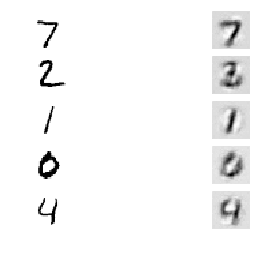

In [11]:
n_test_digits = 5

with tf.Session() as sess:
    saver.restore(sess, "./my_model_cache_frozen.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


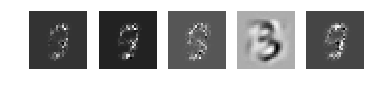

In [23]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
with tf.Session() as sess:
    saver.restore(sess, "./my_model_sparse.ckpt") 
    weights1_val = weights1.eval()

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plot_image(weights1_val.T[i])

plt.show() 

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


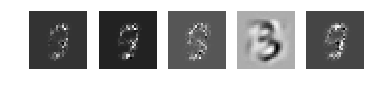

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_cache_frozen.ckpt") # 책에는 없음
    weights4_val = weights4.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights4_val[i])

plt.show() 

In [9]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1) # y 레이블에 대한 logits 예측값이 가장 크면 True 반환
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32)) # Session 실행 시 True -> 1 로 변환

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [28]:
A = tf.cast(True, tf.float32)

In [30]:
B = [True, True, True]
A = tf.cast(B, tf.float32)

Tensor("Cast_5:0", shape=(3,), dtype=float32)


In [32]:
with tf.Session() as sess:
    init.run()
    print(sess.run(A))

[1. 1. 1.]


In [33]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "훈련 정확도:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        test_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("테스트 정확도:", test_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
09% 훈련 정확도: 0.93333334	테스트 정확도: 0.9261
1 훈련 정확도: 0.96666664	테스트 정확도: 0.9312
2 훈련 정확도: 0.99333334	테스트 정확도: 0.9508
3 훈련 정확도: 0.96	테스트 정확도: 0.9433


In [11]:

n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = X_train[indices], y_train[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "검증 세트 정확도:", accuracy_val, end=" ")
        saver.save(sess, "./my_model_supervised.ckpt")
        test_val = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("테스트 정확도:", test_val)

0 검증 세트 정확도: 0.9533333 테스트 정확도: 0.9251
1 검증 세트 정확도: 0.98 테스트 정확도: 0.9457
2 검증 세트 정확도: 0.9866667 테스트 정확도: 0.9523
3 검증 세트 정확도: 0.97333336 테스트 정확도: 0.9437


In [7]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

noise_level = 1.0
l2_reg = 0.0005

activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

weights1 = tf.get_variable(name="weights1", shape = [n_inputs, n_hidden1], initializer = tf.variance_scaling_initializer() )
weights2 = tf.get_variable(name="weights2", shape = [n_hidden1, n_hidden2], initializer = tf.variance_scaling_initializer())
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt") 

0 훈련 MSE: 0.031229466
1 훈련 MSE: 0.027388513
2 훈련 MSE: 0.028974205
3 훈련 MSE: 0.027740829
4 훈련 MSE: 0.026579453
5 훈련 MSE: 0.026890103
6 훈련 MSE: 0.026715524
7 훈련 MSE: 0.02610338
8 훈련 MSE: 0.027194627
9 훈련 MSE: 0.027151573


In [7]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # 코딩 유닛
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

dropout_rate = 0.3
l2_reg = 0.0005

training = tf.placeholder_with_default(False, shape=(), name='training')

activation = tf.nn.relu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

weights1 = tf.get_variable(name="weights1", shape = [n_inputs, n_hidden1], initializer = tf.variance_scaling_initializer() )
weights2 = tf.get_variable(name="weights2", shape = [n_hidden1, n_hidden2], initializer = tf.variance_scaling_initializer())
weights3 = tf.transpose(weights2, name="weights3")  # 가중치 묶기
weights4 = tf.transpose(weights1, name="weights4")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch, training: True})
        print("\r{}".format(epoch), "훈련 MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 훈련 MSE: 0.03128965
1 훈련 MSE: 0.027225215
2 훈련 MSE: 0.028643247
3 훈련 MSE: 0.027846908
4 훈련 MSE: 0.026295586
5 훈련 MSE: 0.026463386
6 훈련 MSE: 0.026466545
7 훈련 MSE: 0.026142955
8 훈련 MSE: 0.028078036
9 훈련 MSE: 0.027768202


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


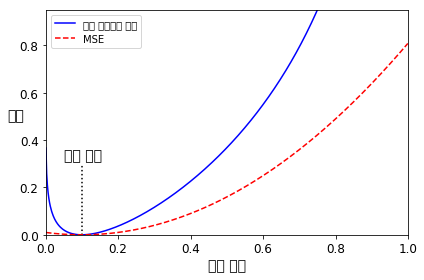

In [8]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "목표 희소", fontsize=14)
plt.plot(q, kl_div, "b-", label="쿨백 라이블러 발산")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("실제 희소")
plt.ylabel("비용", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [10]:
def kl_divergence(p, q):
    # 쿨백 라이블러 발산
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))



reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # 희소 코딩 유닛
n_outputs = n_inputs

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 10# 람다

activation = tf.nn.sigmoid

X = tf.placeholder(tf.float32, shape=[None, n_inputs])           

weights1 = tf.get_variable(name="weights1", shape = [n_inputs, n_hidden1], initializer = tf.variance_scaling_initializer() )
weights2 = tf.transpose(weights1, name="weights2")  # 가중치 묶기

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_outputs), name="biases2")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
outputs = tf.matmul(hidden1, weights2) + biases2 

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # 배치 평균 , 평균 활성화
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean)) 
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_epochs = 30
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss],
                                                                        feed_dict={X: X_batch})
        
        print("\r{}".format(epoch), "훈련 MSE:", reconstruction_loss_val, "\t희소 손실:", sparsity_loss_val,
              "\t전체 손실:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

0 훈련 MSE: 11.504909 	희소 손실: 0.7385365 	전체 손실: 18.890274
1 훈련 MSE: 3.9447372 	희소 손실: 0.048804283 	전체 손실: 4.4327803
2 훈련 MSE: 2.127176 	희소 손실: 0.036829174 	전체 손실: 2.4954677
3 훈련 MSE: 1.2931366 	희소 손실: 0.07116698 	전체 손실: 2.0048065
4 훈련 MSE: 0.93474954 	희소 손실: 0.008649307 	전체 손실: 1.0212426
5 훈련 MSE: 0.77915674 	희소 손실: 0.02357528 	전체 손실: 1.0149095
6 훈련 MSE: 0.6257136 	희소 손실: 0.025285464 	전체 손실: 0.87856823
7 훈련 MSE: 0.6507594 	희소 손실: 0.039472744 	전체 손실: 1.0454868
8 훈련 MSE: 0.6105095 	희소 손실: 0.053438578 	전체 손실: 1.1448953
9 훈련 MSE: 0.6149115 	희소 손실: 0.04413201 	전체 손실: 1.0562316
10 훈련 MSE: 0.5293972 	희소 손실: 0.35430837 	전체 손실: 4.0724807
11 훈련 MSE: 0.5252482 	희소 손실: 0.056133565 	전체 손실: 1.0865839
12 훈련 MSE: 0.5095135 	희소 손실: 0.024389364 	전체 손실: 0.7534071
13 훈련 MSE: 0.5257881 	희소 손실: 0.019457437 	전체 손실: 0.7203625
14 훈련 MSE: 0.49218398 	희소 손실: 0.17685111 	전체 손실: 2.260695
15 훈련 MSE: 0.50250477 	희소 손실: 0.034070946 	전체 손실: 0.8432142
16 훈련 MSE: 0.48696864 	희소 손실: 0.15722114 	전체 손실: 2.05918
17 훈련 MSE: 0.

In [26]:
A = [1,2,3,4,5,6]
activation = tf.nn.sigmoid

initializer = tf.variance_scaling_initializer()
w_init = initializer([2, 2])


w = tf.Variable(w_init, dtype=tf.float32, name="w")
activation(w)

<tf.Tensor 'Sigmoid_10:0' shape=(2, 2) dtype=float32>

In [27]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    print(sess.run(w))
    print(sess.run(activation(w)))
    print(sess.run(tf.reduce_mean(activation(w))))
    print(sess.run(kl_divergence(sparsity_target, tf.reduce_mean(activation(w), axis=0))))
    print(sess.run(kl_divergence(0.01, tf.reduce_mean(activation(w), axis=0))))

[[ 0.3979701  -0.44868386]
 [-0.23796916 -1.1539042 ]]
[[0.59819984 0.38967374]
 [0.44078687 0.23977667]]
0.41710925


NameError: name 'kl_divergence' is not defined

In [28]:
regularizer = tf.contrib.layers.l2_regularizer(0.5)
loss = regularizer(w)

with tf.Session() as sess:
    init.run()
    print(sess.run(w))
    print(sess.run(loss))

[[ 0.3979701  -0.44868386]
 [-0.23796916 -1.1539042 ]]
0.43695542


INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


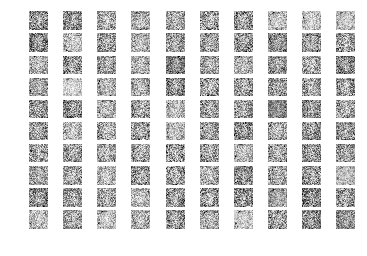

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


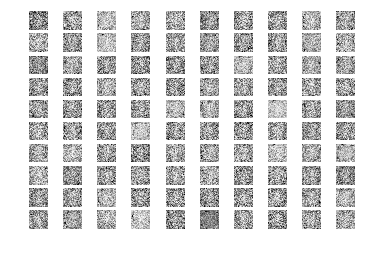

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


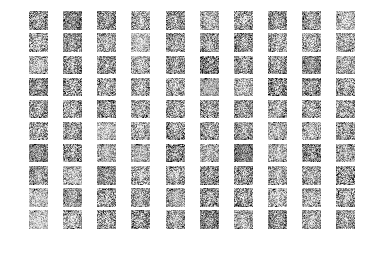

INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


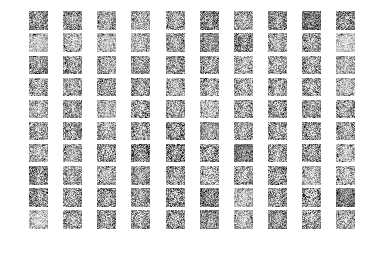

In [11]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
with tf.Session() as sess:
    saver.restore(sess, "./my_model_sparse.ckpt") 
    weights1_val = weights1.eval()

for i in range(100):
    plt.subplot(10, 10, i + 1)
    plot_image(weights1_val.T[i])
save_fig("ex1",tight_layout= False)
plt.show() 


def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
with tf.Session() as sess:
    saver.restore(sess, "./my_model_sparse.ckpt") 
    weights1_val = weights1.eval()

for i in range(100,200):
    plt.subplot(10, 10, i -99)
    plot_image(weights1_val.T[i])
save_fig("ex2",tight_layout= False)
plt.show() 

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
with tf.Session() as sess:
    saver.restore(sess, "./my_model_sparse.ckpt") 
    weights1_val = weights1.eval()

for i in range(200,300):
    plt.subplot(10, 10, i - 199)
    plot_image(weights1_val.T[i])
save_fig("ex3",tight_layout= False)
plt.show() 


def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
with tf.Session() as sess:
    saver.restore(sess, "./my_model_sparse.ckpt") 
    weights1_val = weights1.eval()

for i in range(300,400):
    plt.subplot(10, 10, i -299)
    plot_image(weights1_val.T[i])
save_fig("ex2",tight_layout= False)
plt.show() 